In [51]:
import os
import glob
import zipfile
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models, optimizers
from PIL import Image
from google.colab import files

In [52]:
#Upload Image
uploaded = files.upload()
zip_path = next(iter(uploaded))
extract_dir = './data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Saving B_23.zip to B_23 (1).zip


In [53]:
image_dir = None
for root, dirs, files in os.walk(extract_dir):
    if any(f.lower().endswith((".jpg", ".jpeg", ".png")) for f in files):
        image_dir = root
        break
assert image_dir is not None, "No image files found in extracted zip."
print(f"Images loaded from: {image_dir}")

Images loaded from: ./data/B_23


In [54]:
os.listdir('./data/B_23')

['siirt 438.jpg',
 'kirmizi 690.jpg',
 'kirmizi 1147.jpg',
 'kirmizi 881.jpg',
 'kirmizi 1145.jpg',
 'kirmizi 651.jpg',
 'kirmizi 1067.jpg',
 'siirt 649.jpg',
 'siirt 443.jpg',
 'kirmizi 930.jpg',
 'siirt 708.jpg',
 'kirmizi 1118.jpg',
 'siirt 565.jpg',
 'siirt 503.jpg',
 'siirt 422.jpg',
 'kirmizi 566.jpg',
 'kirmizi 733.jpg',
 'kirmizi 941.jpg',
 'kirmizi 701.jpg',
 'kirmizi 700.jpg',
 'kirmizi 996.jpg',
 'kirmizi 1087.jpg',
 'siirt 812.jpg',
 'siirt 608.jpg',
 'kirmizi 1065.jpg',
 'kirmizi 1071.jpg',
 'siirt 573.jpg',
 'siirt 751.jpg',
 'siirt 742.jpg',
 'kirmizi 1066.jpg',
 'kirmizi 663.jpg',
 'kirmizi 1133.jpg',
 'siirt 626.jpg',
 'siirt 786.jpg',
 'siirt 761.jpg',
 'siirt 613.jpg',
 'kirmizi 687.jpg',
 'kirmizi 1050.jpg',
 'siirt 771.jpg',
 'kirmizi 818.jpg',
 'kirmizi 1046.jpg',
 'kirmizi 689.jpg',
 'siirt 815.jpg',
 'kirmizi 1164.jpg',
 'kirmizi 955.jpg',
 'kirmizi 747.jpg',
 'kirmizi 780.jpg',
 'kirmizi 802.jpg',
 'siirt 602.jpg',
 'kirmizi 1151.jpg',
 'kirmizi 611.jpg',
 'sii

In [55]:
# Load Image
def load_images_from_folder(folder, target_size=(100, 100)):
    images = []
    for ext in ('*.jpg', '*.jpeg', '*.png'):
        for filename in glob.glob(os.path.join(folder, '**', ext), recursive=True):
            img = Image.open(filename).convert('RGB')
            img = img.resize(target_size)
            arr = np.array(img, dtype='float32')
            # normalize ke [-1,1]
            arr = (arr / 127.5) - 1.0
            images.append(arr)
    if not images:
        raise ValueError(f"No images found in folder {folder}")
    return np.stack(images, axis=0)

all_images = load_images_from_folder(image_dir, target_size=img_size)
print(f"Loaded {len(all_images)} images with shape {all_images.shape}")

Loaded 1074 images with shape (1074, 100, 100, 3)


Karena menggunakan Tanh sebagai output, maka kita perlu melakukan normalize data

# Modeling

In [56]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam

In [57]:
def build_generator():
    model = models.Sequential(name='Generator')
    model.add(layers.Input(shape=(100,)))
    model.add(layers.Dense(100 * 100 * 1))  # use single-channel feature base
    model.add(layers.Reshape((100, 100, 1)))

    model.add(layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu'))  # 98x98x16
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu'))  # 96x96x32
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu'))  # 94x94x64

    model.add(layers.Conv2D(3, kernel_size=3, strides=1, padding='valid', activation='tanh'))  # 92x92x3
    model.add(layers.Resizing(100, 100))  # Resize to match Discriminator input
    return model

# --- Discriminator: Accepts 100x100x3 ---
def build_discriminator():
    model = models.Sequential(name='Discriminator')
    model.add(layers.Input(shape=(100, 100, 3)))
    model.add(layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# --- Compile Models ---
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

# Build GAN
gan_input = layers.Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output, name='GAN')
gan.compile(optimizer=Adam(), loss='binary_crossentropy')

In [58]:
def train_gan(generator,discriminator,gan,data,epochs=1000,batch_size=32,noise_dim=100,log_step=10,save_freq=None
):

    half_batch = batch_size // 2

    for epoch in range(1, epochs + 1):
        # --- Train Discriminator ---
        idx       = np.random.randint(0, data.shape[0], half_batch)
        real_imgs = data[idx]
        noise     = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_imgs = generator.predict(noise, verbose=0)
        d_loss_real, d_acc_real = discriminator.train_on_batch(
            real_imgs, np.ones((half_batch, 1))
        )
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(
            fake_imgs, np.zeros((half_batch, 1))
        )
        # rata‑ratakan
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc  = 0.5 * (d_acc_real  + d_acc_fake)

        # --- Train Generator ---
        noise  = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        # --- Log Progress ---
        if epoch == 1 or epoch % log_step == 0:
            print(
                f"Epoch {epoch}/{epochs} — "
                f"D_loss: {d_loss:.4f}, D_acc: {100*d_acc:.2f}% — "
                f"G_loss: {g_loss:.4f}"
            )
        # --- Optional: Save Sample Images ---
        if save_freq and epoch % save_freq == 0:
            samples = generator.predict(
                np.random.normal(0,1,(16, noise_dim)), verbose=0
            )
            # misal: simpan grid 4×4 dengan matplotlib
            # (kode saving bisa ditambahkan di sini)

    print("Training completed.")


In [59]:
train_gan(generator, discriminator, gan, all_images, epochs=1000)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/1000 — D_loss: 0.7239, D_acc: 7.81% — G_loss: 0.6929
Epoch 10/1000 — D_loss: 0.7211, D_acc: 3.85% — G_loss: 0.6806
Epoch 20/1000 — D_loss: 0.7410, D_acc: 2.53% — G_loss: 0.6441
Epoch 30/1000 — D_loss: 0.7713, D_acc: 2.10% — G_loss: 0.5976
Epoch 40/1000 — D_loss: 0.8268, D_acc: 2.04% — G_loss: 0.5324
Epoch 50/1000 — D_loss: 0.8941, D_acc: 1.82% — G_loss: 0.4715
Epoch 60/1000 — D_loss: 0.9641, D_acc: 1.78% — G_loss: 0.4199
Epoch 70/1000 — D_loss: 1.0355, D_acc: 1.70% — G_loss: 0.3768
Epoch 80/1000 — D_loss: 1.1059, D_acc: 1.53% — G_loss: 0.3410
Epoch 90/1000 — D_loss: 1.1727, D_acc: 1.50% — G_loss: 0.3110
Epoch 100/1000 — D_loss: 1.2345, D_acc: 1.47% — G_loss: 0.2859
Epoch 110/1000 — D_loss: 1.2917, D_acc: 1.42% — G_loss: 0.2646
Epoch 120/1000 — D_loss: 1.3437, D_acc: 1.59% — G_loss: 0.2464
Epoch 130/1000 — D_loss: 1.3918, D_acc: 1.52% — G_loss: 0.2307
Epoch 140/1000 — D_loss: 1.4358, D_acc: 1.59% — G_loss: 0.2169
Epoch 150/1000 — D_loss: 1.4770, D_acc: 1.57% — G_loss: 0.2048
Epo

Dari hasil training model GAN baseline, menunjukkan  bahwa nilai discriminator loss (D_loss) mengalami peningkatan terus menerus yang awalnya dari 0.72 menjadi 2.81, sementara itu pada discriminator accuracy (D_acc) mengalami stagnan di kisaran 1.3%. Dan pada generator loss (G_loss) terus menurun drastis hingga mencapai 0.036. Hal ini mengindikasikan bahwa generator terlalu mendominasi dan berhasil menipu discriminator secara konsisten, namun discriminator tidak mampu belajar membedakan gambar asli dan palsu.

Sehingga discriminator tidak mampu belajar apapun dari data yang telah disiapkan.

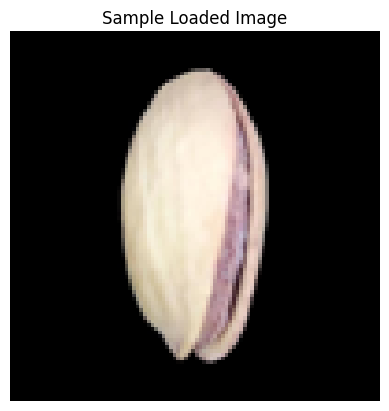

In [60]:
sample_img = (all_images[0] + 1.0) * 127.5
sample_img = sample_img.astype(np.uint8)

plt.imshow(sample_img)
plt.axis('off')
plt.title("Sample Loaded Image")
plt.show()

# MODIFIKASI MODEL

In [61]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_generator_mod():
    model = models.Sequential(name='Generator_mod')
    model.add(layers.Input(shape=(100,)))
    # Dense → reshape ke fitur kecil
    model.add(layers.Dense(25*25*128, activation='relu'))
    model.add(layers.Reshape((25, 25, 128)))

    # Upsample 25→50
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Upsample 50→100
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Output 100×100×3
    model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return model

def build_discriminator_mod():
    model = models.Sequential(name='Discriminator_mod')
    model.add(layers.Input(shape=(100, 100, 3)))

    # Conv → downsample 100→50
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    # Conv → downsample 50→25
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    # Conv (cukup ekstraksi fitur)
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Compile
generator_mod = build_generator_mod()
discriminator_mod = build_discriminator_mod()
discriminator_mod.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
discriminator_mod.trainable = False

# Build and compile GAN
gan_input  = layers.Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output, name='GAN_mod')
gan.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')


In [62]:
def train_gan(generator, discriminator, gan, data,epochs=1000, batch_size=32, noise_dim=100,log_step=10, save_freq=None):
    half_batch = batch_size // 2
    for epoch in range(1, epochs + 1):
        # Train Discriminator
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_imgs = data[idx]

        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        d_loss_real, d_acc_real = discriminator.train_on_batch(
            real_imgs, np.ones((half_batch, 1))
        )
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(
            fake_imgs, np.zeros((half_batch, 1))
        )

        # Rata-rata loss dan akurasi
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        # Train Generator via GAN
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Log Progress
        if epoch == 1 or epoch % log_step == 0:
            print(
                f"Epoch {epoch}/{epochs} — "
                f"D_loss: {d_loss:.4f}, D_acc: {100 * d_acc:.2f}% — "
                f"G_loss: {g_loss:.4f}"
            )

    print("Training completed.")

In [63]:

train_gan(generator_mod,discriminator,gan,data=all_images,epochs=1000,
          batch_size=32,noise_dim=100,log_step=10,save_freq=100
)


Epoch 1/1000 — D_loss: 2.8127, D_acc: 1.31% — G_loss: 0.0016
Epoch 10/1000 — D_loss: 2.7940, D_acc: 1.64% — G_loss: 0.0016
Epoch 20/1000 — D_loss: 2.7736, D_acc: 2.01% — G_loss: 0.0016
Epoch 30/1000 — D_loss: 2.7536, D_acc: 2.33% — G_loss: 0.0016
Epoch 40/1000 — D_loss: 2.7340, D_acc: 2.68% — G_loss: 0.0016
Epoch 50/1000 — D_loss: 2.7148, D_acc: 3.02% — G_loss: 0.0016
Epoch 60/1000 — D_loss: 2.6960, D_acc: 3.33% — G_loss: 0.0016
Epoch 70/1000 — D_loss: 2.6774, D_acc: 3.68% — G_loss: 0.0015
Epoch 80/1000 — D_loss: 2.6593, D_acc: 4.03% — G_loss: 0.0015
Epoch 90/1000 — D_loss: 2.6414, D_acc: 4.35% — G_loss: 0.0015
Epoch 100/1000 — D_loss: 2.6239, D_acc: 4.68% — G_loss: 0.0015
Epoch 110/1000 — D_loss: 2.6067, D_acc: 4.99% — G_loss: 0.0015
Epoch 120/1000 — D_loss: 2.5898, D_acc: 5.28% — G_loss: 0.0015
Epoch 130/1000 — D_loss: 2.5733, D_acc: 5.55% — G_loss: 0.0015
Epoch 140/1000 — D_loss: 2.5570, D_acc: 5.86% — G_loss: 0.0015
Epoch 150/1000 — D_loss: 2.5410, D_acc: 6.15% — G_loss: 0.0015
Epo

Pada hasil training generator modifikasi menunjukkan performa yang lebih stabil ketimbang baseline. Ditunjukkan pada discriminator loss menurun dari 2.81 menjadi 1.76, sementara akurasinya meningkat dari 1.3% menjadi 20.1%, menandakan peningkatan kemampuan dalam membedakan gambar asli dan palsu. Generator loss tetap sangat rendah (~0.001), menunjukkan konsistensi dalam menipu discriminator. Dibandingkan dengan baseline yang mengalami training collapse dan ketidakseimbangan antara D dan G, model modifikasi menunjukkan pelatihan yang lebih seimbang.

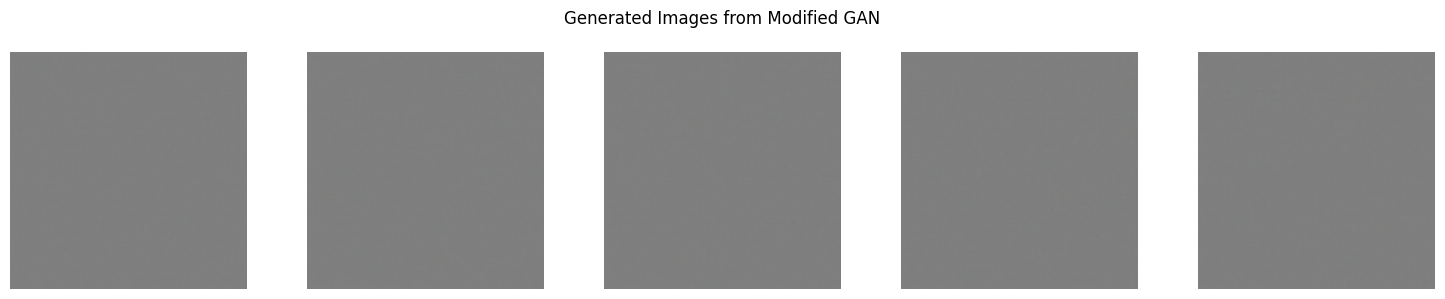

In [64]:
def generate_and_plot_images(generator, n_samples=5, noise_dim=100, title="Generated Images from Modified GAN"):
    # Generate images from random noise
    noise = np.random.normal(0, 1, (n_samples, noise_dim))
    generated_imgs = generator.predict(noise, verbose=0)

    # Unnormalize and convert to uint8
    generated_imgs = (generated_imgs + 1.0) * 127.5
    generated_imgs = np.clip(generated_imgs, 0, 255).astype(np.uint8)

    # Plot
    plt.figure(figsize=(3 * n_samples, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_imgs[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Contoh pemanggilan:
generate_and_plot_images(generator_mod, n_samples=5, noise_dim=100)


# Evaluasi dengan FID

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

In [66]:
# Helper: Get Inception Activations
def get_activations(images, model):
    images = tf.image.resize(images, (299, 299))                       # Resize ke 299x299
    images = preprocess_input(images * 127.5 + 127.5)                  # [-1,1] → [0,255] → preprocess
    return model.predict(images, verbose=0)

# Helper: FID Calculation
def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Load InceptionV3 (tanpa top)
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Real & Generated Image Samples
n_samples = 100
real_imgs = tf.convert_to_tensor(all_images[:n_samples], dtype=tf.float32)

noise = np.random.normal(0, 1, (n_samples, 100))

fake_base = generator.predict(noise, verbose=0)      # Baseline Generator
fake_mod  = generator_mod.predict(noise, verbose=0)      # Modified Generator

# Get Inception Features
act_real  = get_activations(real_imgs, inception)
act_base  = get_activations(fake_base, inception)
act_mod   = get_activations(fake_mod, inception)

# Calculate FID
fid_base = calculate_fid(act_real, act_base)
fid_mod  = calculate_fid(act_real, act_mod)

# Output Result
print(" FID Score Comparison")
print("------------------------")
print(f"Baseline Generator FID : {fid_base:.2f}")
print(f"Modified Generator FID : {fid_mod:.2f}")

 FID Score Comparison
------------------------
Baseline Generator FID : 574.23
Modified Generator FID : 550.76


Semakin rendah scor yang didapat menandakan bahwa model yang dikembangkan semakin baik, seperti scor yang mendekati nilai, model mampu membedakan gambar palsu maupun asli.  

Melalui hasil evaluasi FID menunjukkan bahwa generator modifikasi menghasilkan skor FID yang lebih rendah (550.76) dibandingkan baseline (574.23), yang berarti gambar yang dihasilkan oleh model modifikasi secara statistik lebih mendekati distribusi gambar asli. Meskipun perbedaannya tidak terlalu besar, hal ini mengindikasikan bahwa arsitektur modifikasi memberikan peningkatan kualitas output dibandingkan model baseline.

# LINK VIDEO:

https://drive.google.com/drive/folders/1yWCgGCAcEFNAKjsQ7pFCG17R5ox9kW5L?usp=drive_link